### General object detection using MobileNet V2 and SSD 

Steps are:

1. Manually download (MobileNet-SSD V2) weights (.pb) and config/network architecture(.pbtxt) from here:
https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 

2. Unzip it inside the models directory.

3. Note that it is the same model as provided in OpenVINO model zoo, so you can use 01_model_downloader notebook. However, I have found that it misses .pbtxt file in it and without it, inference throws an error. Anyway, it is a good example of using TF model repo. 

4. Details about the models are here: https://docs.openvinotoolkit.org/latest/omz_models_public_ssd_mobilenet_v2_coco_ssd_mobilenet_v2_coco.html

In summary:
* Input size - (300, 300)
* Channel order - RGB
* Model is trained on MSCOCO (so 80 classes are used although they mention 91 in total)
* Output format - [1, 1, N, 7]

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

%matplotlib inline

#### Define parameters

In [3]:
# Parameters
IMG_FPATH = "./images/skateboard.jpg" # or laptops.jpg
MODEL_FPATH = './models/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb'
ARCH_FPATH = './models/ssd_mobilenet_v2_coco_2018_03_29/ssd_mobilenet_v2_coco_2018_03_29.pbtxt'
COCO_LABELS_FPATH = './coco_labels.json' # model is trained on MSCOCO dataset (80 classes)
CONF_THRESH = 0.5 # object detection confence

#### Load JSON file containing classes of MSCOCO dataset

In [4]:
# load coco labels/classes
with open(COCO_LABELS_FPATH , 'r') as f:
    coco_class_names = json.load(f)
    
print(coco_class_names)

{'0': 'background', '1': 'person', '2': 'bicycle', '3': 'car', '4': 'motorcycle', '5': 'airplane', '6': 'bus', '7': 'train', '8': 'truck', '9': 'boat', '10': 'traffic light', '11': 'fire hydrant', '13': 'stop sign', '14': 'parking meter', '15': 'bench', '16': 'bird', '17': 'cat', '18': 'dog', '19': 'horse', '20': 'sheep', '21': 'cow', '22': 'elephant', '23': 'bear', '24': 'zebra', '25': 'giraffe', '27': 'backpack', '28': 'umbrella', '31': 'handbag', '32': 'tie', '33': 'suitcase', '34': 'frisbee', '35': 'skis', '36': 'snowboard', '37': 'sports ball', '38': 'kite', '39': 'baseball bat', '40': 'baseball glove', '41': 'skateboard', '42': 'surfboard', '43': 'tennis racket', '44': 'bottle', '46': 'wine glass', '47': 'cup', '48': 'fork', '49': 'knife', '50': 'spoon', '51': 'bowl', '52': 'banana', '53': 'apple', '54': 'sandwich', '55': 'orange', '56': 'broccoli', '57': 'carrot', '58': 'hot dog', '59': 'pizza', '60': 'donut', '61': 'cake', '62': 'chair', '63': 'couch', '64': 'potted plant', '65

#### Model configuration for the input image

In [5]:
@dataclass
class ModelConfig:
    scalefactor: float = 1.0
    size: tuple = (224, 224)
    mean: tuple = (0, 0, 0)
    swapRB: bool = False
    crop: bool = False
    ddepth: int = cv2.CV_32F

configs = vars(ModelConfig(size=(300, 300), swapRB=True))
print(configs)

{'scalefactor': 1.0, 'size': (300, 300), 'mean': (0, 0, 0), 'swapRB': True, 'crop': False, 'ddepth': 5}


#### Load image and create a blob

In [6]:
# Load image and prepare a blob which is going to be input to the model
img = cv2.imread(IMG_FPATH)
if img is None:
    raise Exception(f'Image not found with the path provided: {IMG_FPATH}')

img_height, img_width = img.shape[:2]
blob = cv2.dnn.blobFromImage(img,
                             scalefactor=configs['scalefactor'],
                             size=configs['size'],
                             mean=configs['mean'],
                             swapRB=configs['swapRB'],
                             crop=configs['crop'],
                             ddepth=configs['ddepth'])

print(blob.shape) # Blob returns in NCHW format

(1, 3, 300, 300)


#### Load model and run inference

In [7]:
# Load model
net = cv2.dnn.readNetFromTensorflow(MODEL_FPATH, ARCH_FPATH)

# Specify target device
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_INFERENCE_ENGINE)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Run inference
net.setInput(blob)
detections = net.forward()

#### Show bounding boxes

In [8]:
def show_img(img):
    dpi = 80
    height, width, _ = img.shape
    figsize = width / float(dpi), height / float(dpi)
    
    fig = plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

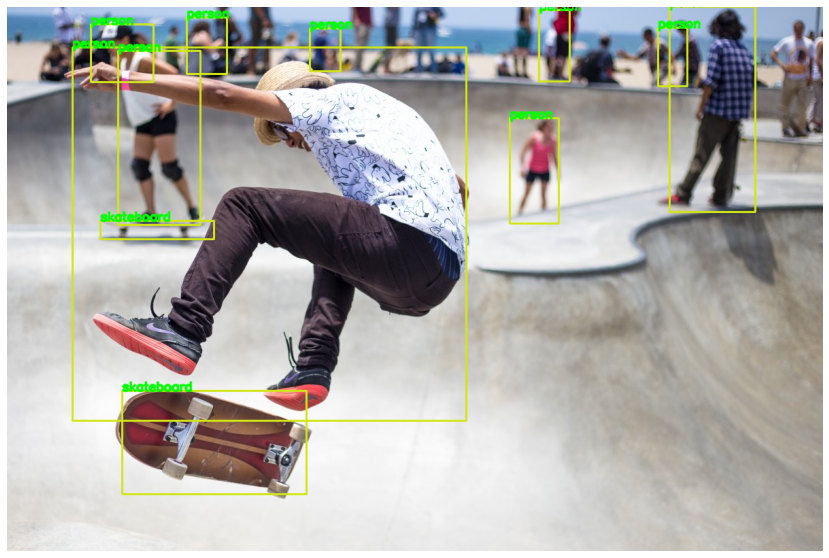

In [9]:
# iterate over each detection and plot a BB on the image
for detect in detections[0, 0, :, :]:
    conf = detect[2]
    # show the BB only of certain confidence threshold
    if conf > CONF_THRESH:
        class_id = int(detect[1])
        class_name = coco_class_names[str(class_id)]
        left = detect[3]*img_width
        top = detect[4]*img_height
        right = detect[5]*img_width
        bottom = detect[6]*img_height
        cv2.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), (23, 230, 210), thickness=2)
        cv2.putText(img, class_name, (int(left), int(top)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)
show_img(img)